# Predictive maintenance of a CNC milling machine

In machine cutting processes, in order to ensure surface finish quality, it is imperative to keep the tool used in top operative condition. One approach to monitor the machine wear is to measure certain process parameters, such as cutting force, tool vibration and acoustics emissions.

## The data source

The data was collected from a high speed CNC (computer numerical control) machine (Röders Tech RFM760) cutting stainless steel (HRC52). A platform dynamometer was used for measuring cutting force, three accelerometer was mounted to detect tool vibration in different directions, and a specialised sensor monitored the acoustic emission levels. The outputs of these sensors were caputred by corresponding signal conditioning accessories.


| ![picture showing sensor equipment locations on a high speed cnc milling machine](../notebooks/figures/milling_machine_setup.jpeg) |
|:--:|
| Sensor equipment locations on a high speed cnc milling machine <br> (Source: __[Li, X., S. Lim, B., H. Zhou, J., Huang, S., J. Phua, S., C. Shaw, K., & J. Er, M. (2021). Fuzzy Neural Network Modelling for Tool Wear Estimation in Dry Milling Operation. Annual Conference of the PHM Society](https://papers.phmsociety.org/index.php/phmconf/article/view/1403)__) |

### Milling cutters

Milling cutters (or bits) are the changable parts of a CNC machine. These parts do the cutting or drilling of the materials handled (in this case steel). Both the hole drilling and cutting are executed by the spinning motion of these milling bits, which come in different shapes, sizes and materials. 

| ![picture showing various milling cutters ](../notebooks/figures/milling-bit-list.webp) |
|:--:|
| Milling cutter examples <br> (Source: __[CNC Masters](https://www.cncmasters.com/milling-bits/)__)|

### Flutes

Flutes are the grooves formed between the teeth of a milling cutter. While the cutter rotates, the flutes direct the material chips away from the workpiece. As the tooth and flutes are identical in number (in fact, they form each other), both terms can be used interchangeably when a milling bit is described. The cutting data collected, involves milling cutters with 3 flutes.

| ![picture pointing out various parts of a milling cutter ](../notebooks/figures/flute_structure.png) |
|:--:|
| Structure of a milling cutter <br> (Source: __[Snapmaker](https://support.snapmaker.com/hc/en-us/articles/4420759543959-CNC-Router-Bits-Basics-Terms-and-Common-Types/)__) |

| ![picture illustrating the difference between having 2, 3 or 4 flutes on a milling bit ](../notebooks/figures/flutes.png) |
|:--:|
| Cross-sectional illustration of milling bits with 2, 3 and 4 flutes <br> (Source: __[Carnegie Mellon’s School of Computer Science](https://www.cs.cmu.edu/~rapidproto/students.03/zdb/project2/CNCflutes.htm)__) |

## The data set

The data set consists of .csv (comma separated value) files and can be downloaded in a compressed folder (.zip). Following extraction (unzipping), there are six individual cutter records (folders c1-c6) out of which:
- c1, c4 and c6 are for training
- c2, c3 and c5 are for testing

Each training record contains a subfolder (named identical to the parent folder) and a wear file. Within the subfolder, 315 files contain the data of a single cut (one file for each cut). In these files:
- Column 1: Force (N) in X dimension
- Column 2: Force (N) in Y dimension
- Column 3: Force (N) in Z dimension
- Column 4: Vibration (g) in X dimension
- Column 5: Vibration (g) in Y dimension
- Column 6: Vibration (g) in Z dimension
- Column 7: AE-RMS (V)*
<br>
*AE-RMS means: effective average value of an acoustic emission signal

### Data importing and preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


Loading data for a single cut in the 4th cutting record set

In [2]:
data_cut = pd.read_csv('../notebooks/data/raw/c4/c4/c_4_001.csv', sep=',', header=None)

Checking data for null or missing values:

In [3]:
data_cut.isnull()

,0,1,2,3,4,5,6
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
165592,False,False,False,False,False,False,False
165593,False,False,False,False,False,False,False
165594,False,False,False,False,False,False,False
165595,False,False,False,False,False,False,False


In [4]:
data_cut.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

Based on the results, no "null" or missing data were detected in the file.

First ten rows of the data set:

In [5]:
data_cut.columns = ['Force X', 'Force Y', 'Force Z', 'Vibration X', 'Vibration Y', 'Vibration Z', 'AE-RMS']
data_cut.head(10)

,Force X,Force Y,Force Z,Vibration X,Vibration Y,Vibration Z,AE-RMS
0,0.916,4.370,-1.372,0.102,0.041,0.069,0.018
1,0.892,3.955,-1.277,0.015,-0.099,-0.066,0.018
2,0.908,3.334,-1.193,0.033,-0.098,-0.059,0.018
3,1.013,3.022,-1.082,0.151,0.015,0.035,0.018
4,1.111,2.970,-1.103,-0.048,-0.175,-0.171,0.019
5,1.302,3.043,-1.089,0.011,-0.085,-0.097,0.018
6,1.552,3.017,-1.052,0.066,-0.002,-0.036,0.019
7,1.832,2.796,-0.933,0.002,-0.028,-0.075,0.019
8,2.127,2.521,-0.749,0.011,0.041,-0.022,0.019
9,2.354,2.311,-0.623,-0.038,0.012,-0.056,0.019


### Visualisation of signal types

According to the competition description, measurements were aquired every 0.02 ms.

In [6]:
# Sampling interval in seconds (0.02 ms = 0.00002 seconds)
sampling_interval = 0.00002  
num_measurements = len(data_cut)
time = np.arange(0, num_measurements * sampling_interval, sampling_interval)
data_cut['time'] = time

### Force measured

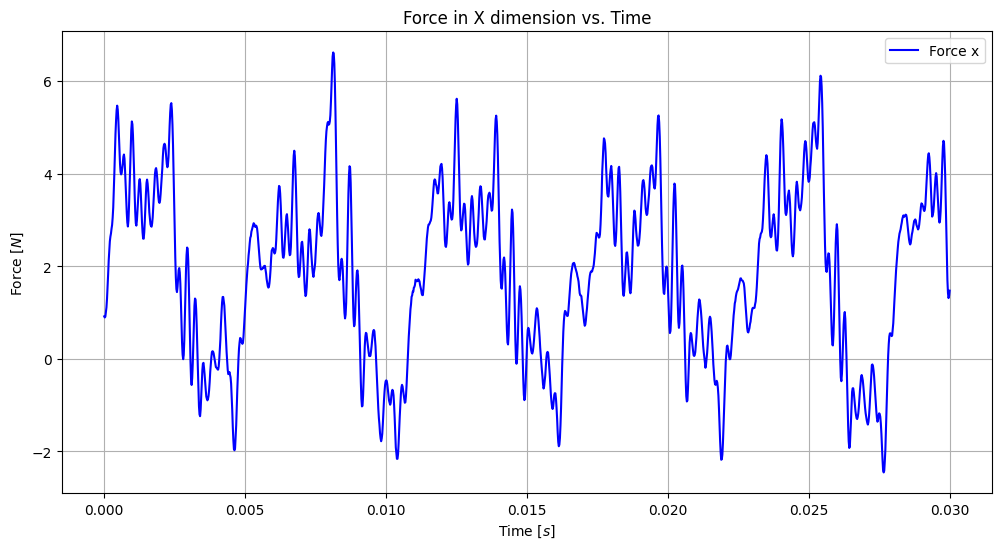

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force X'][:1500], label='Force x', color='b')
plt.title('Force in X dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

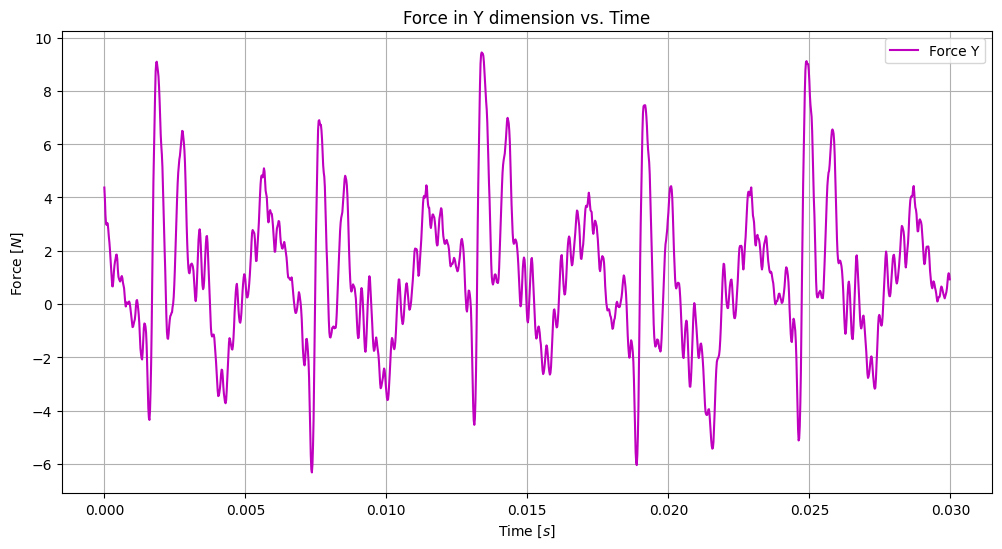

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Y'][:1500], label='Force Y', color='m')
plt.title('Force in Y dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

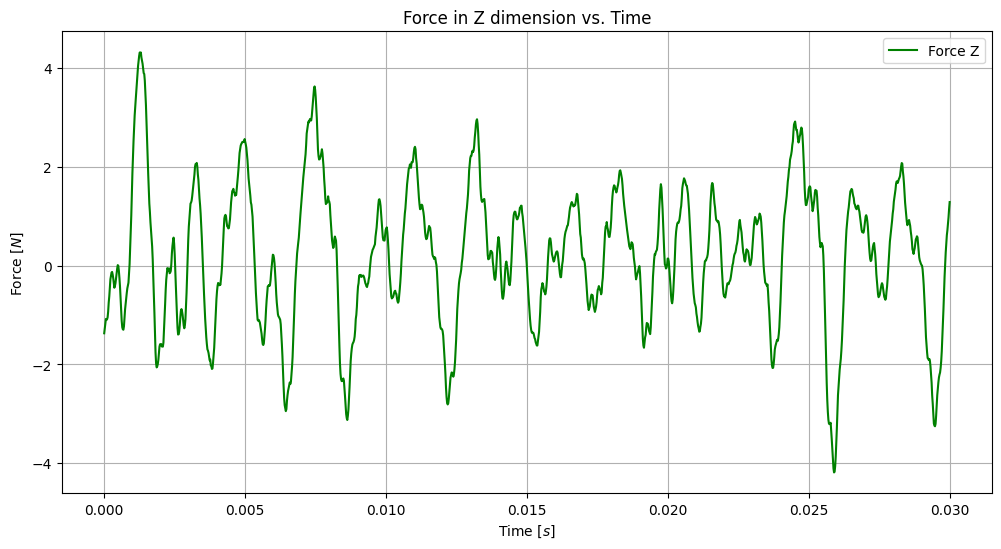

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Z'][:1500], label='Force Z', color='g')
plt.title('Force in Z dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

### Vibration measured

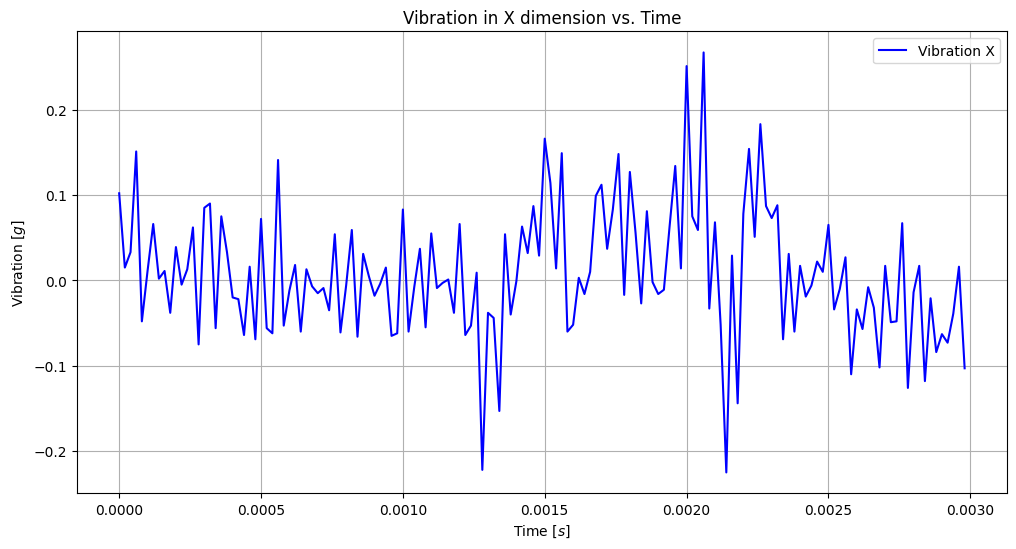

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration X'][:150], label='Vibration X', color='b')
plt.title('Vibration in X dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

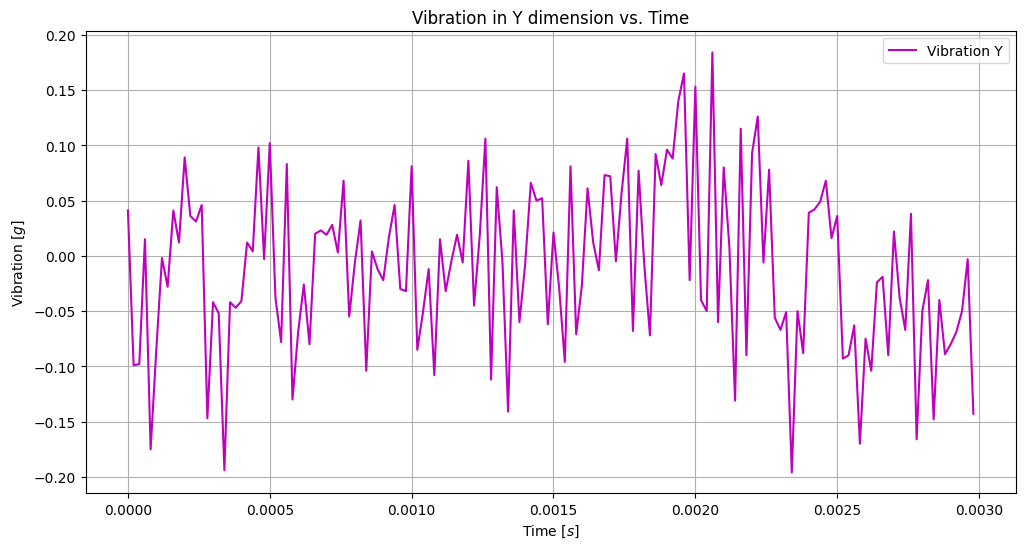

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Y'][:150], label='Vibration Y', color='m')
plt.title('Vibration in Y dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

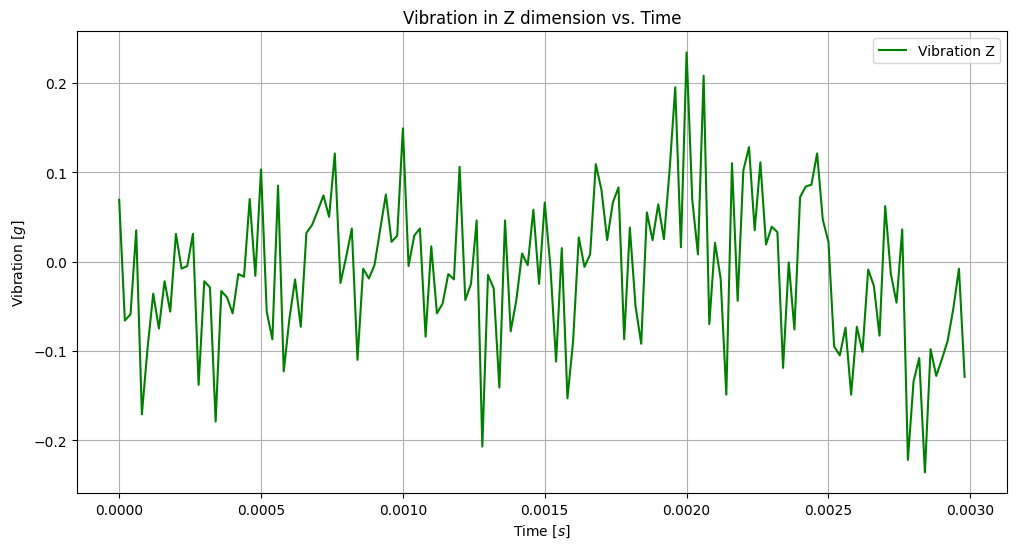

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Z'][:150], label='Vibration Z', color='g')
plt.title('Vibration in Z dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

### Acoustic emission measured

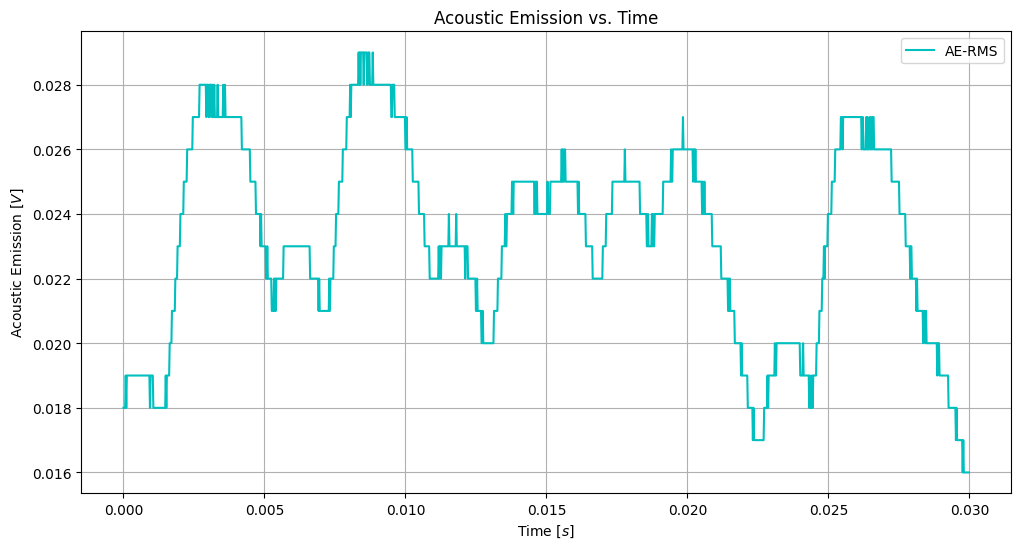

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['AE-RMS'][:1500], label='AE-RMS', color='c')
plt.title('Acoustic Emission vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Acoustic Emission [$V$]')
plt.grid()
plt.legend()
plt.show()

### Importing and preprocessing of wear data

Loading wear data for the 4th cutting record set:

In [14]:
data_wear = pd.read_csv('../notebooks/data/raw/c4/c4_wear.csv', sep=',')

Checking wear data for null or missing values:

In [15]:
data_wear.isnull()

,cut,flute_1,flute_2,flute_3
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
310,False,False,False,False
311,False,False,False,False
312,False,False,False,False
313,False,False,False,False


In [16]:
data_wear.isnull().sum()

cut        0
flute_1    0
flute_2    0
flute_3    0
dtype: int64

Based on the results, no "null" or missing data were detected in the file.

First 10 rows of the wear data:

In [17]:
data_wear.head(10)

,cut,flute_1,flute_2,flute_3
0,1,31.416355,19.483692,21.748063
1,2,34.892770,23.473047,24.925960
2,3,38.102847,27.172868,27.898659
3,4,41.061023,30.599309,30.677848
4,5,43.781191,33.767870,33.274721
5,6,46.276710,36.693424,35.699993
6,7,48.560421,39.390229,37.963919
7,8,50.644660,41.871953,40.076300
8,9,52.541276,44.151684,42.046507
9,10,54.261641,46.241954,43.883488


## Visualization of wear data

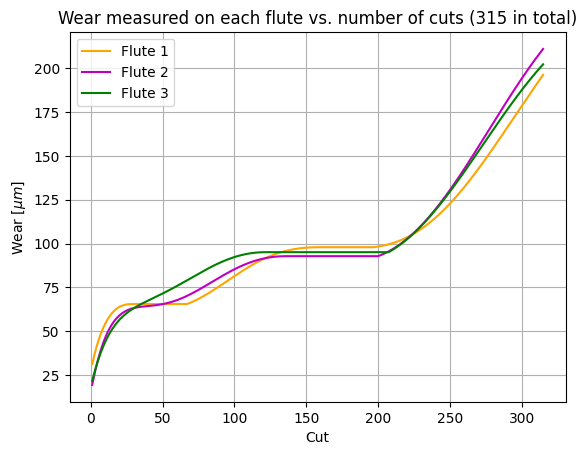

In [18]:
plt.plot(data_wear["cut"], data_wear["flute_1"], label = "Flute 1", color='orange' )
plt.plot(data_wear["cut"] ,data_wear["flute_2"], label = "Flute 2", color='m')
plt.plot(data_wear["cut"], data_wear["flute_3"], label = "Flute 3", color='g')
plt.title('Wear measured on each flute vs. number of cuts (315 in total)')
plt.xlabel('Cut')
plt.ylabel(r'Wear $[\mu m]$')
plt.grid()
plt.legend()
plt.show()

## Sample Data Analysis

### Force measured

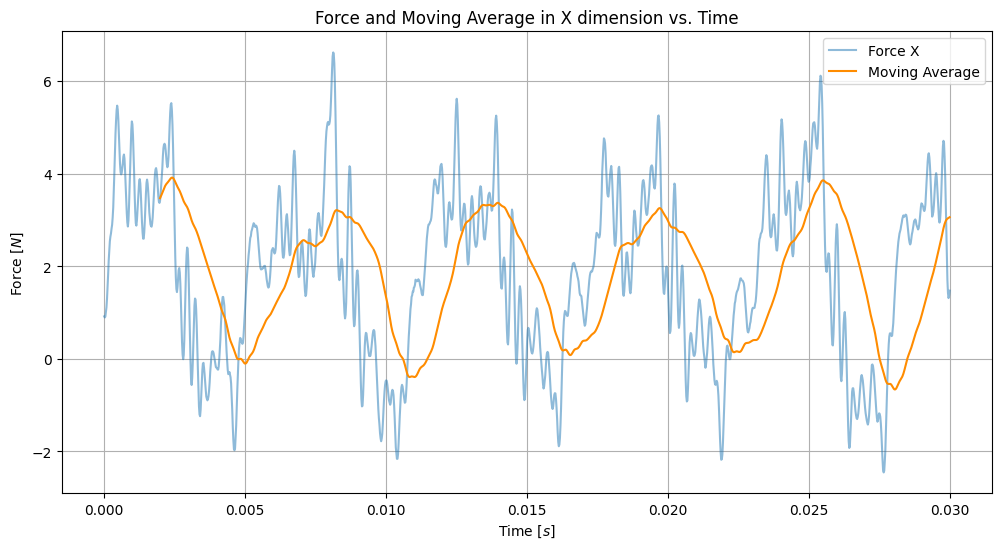

In [19]:
window_size = 100
data_cut['moving_average'] = data_cut['Force X'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force X'][:1500], label='Force X', alpha=0.5)
plt.plot(data_cut['time'][:1500], data_cut['moving_average'][:1500], label='Moving Average', color='#FF8C00')
plt.title('Force and Moving Average in X dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

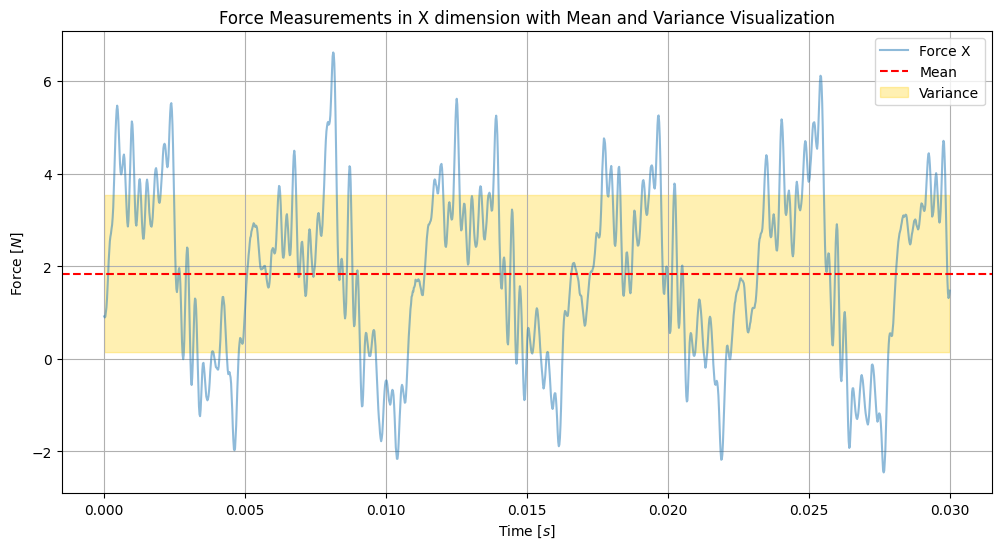

In [20]:
mean = data_cut['Force X'].mean()
variance = data_cut['Force X'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force X'][:1500], label='Force X', alpha=0.5)
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:1500], mean - std_dev, mean + std_dev, color='#FFCE00', alpha=0.3, label='Variance')
plt.title('Force Measurements in X dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

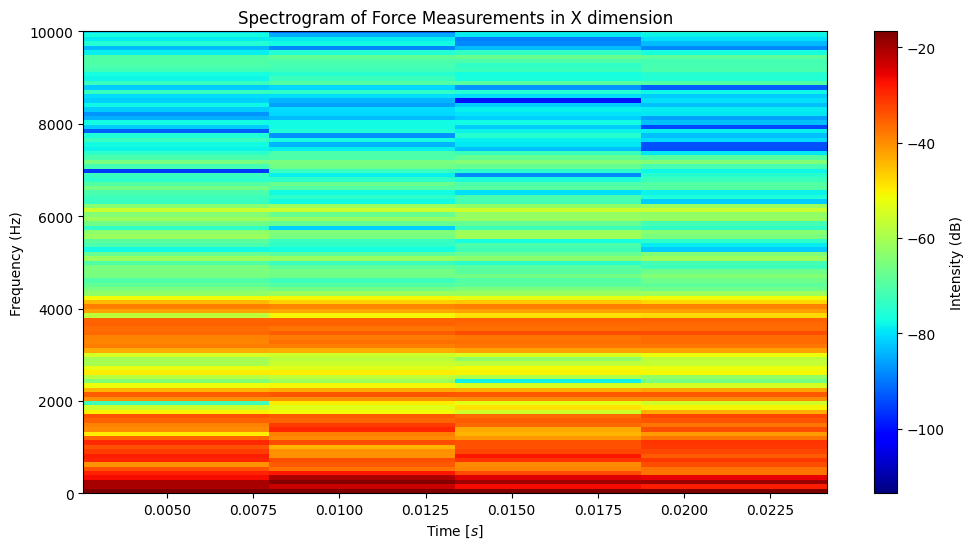

In [21]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Force X'][:1500], Fs=1/sampling_interval, NFFT=526, noverlap=256, cmap='jet')
plt.title('Spectrogram of Force Measurements in X dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 10000) 
plt.show()

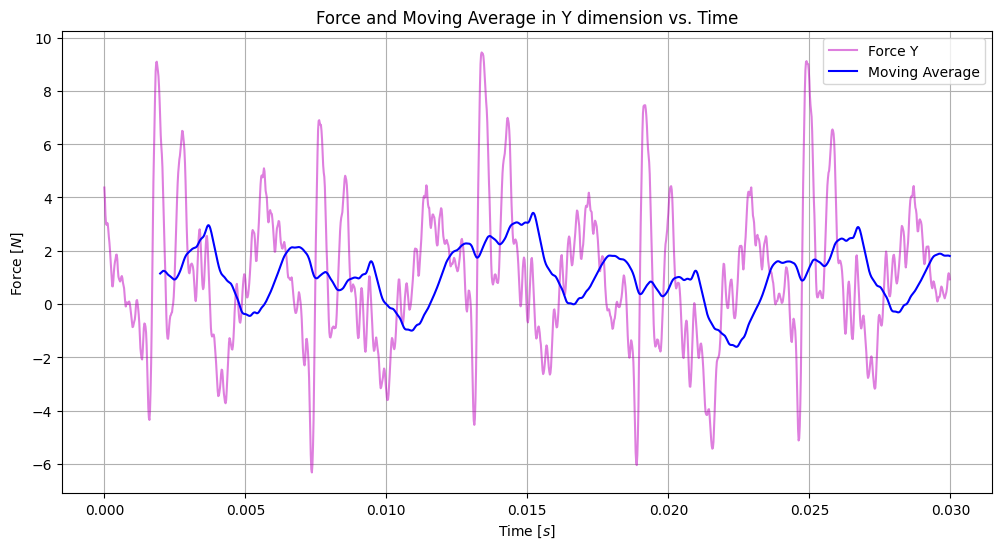

In [22]:
window_size = 100
data_cut['moving_average'] = data_cut['Force Y'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Y'][:1500], label='Force Y', color='m', alpha=0.5)
plt.plot(data_cut['time'][:1500], data_cut['moving_average'][:1500], label='Moving Average', color='b')
plt.title('Force and Moving Average in Y dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

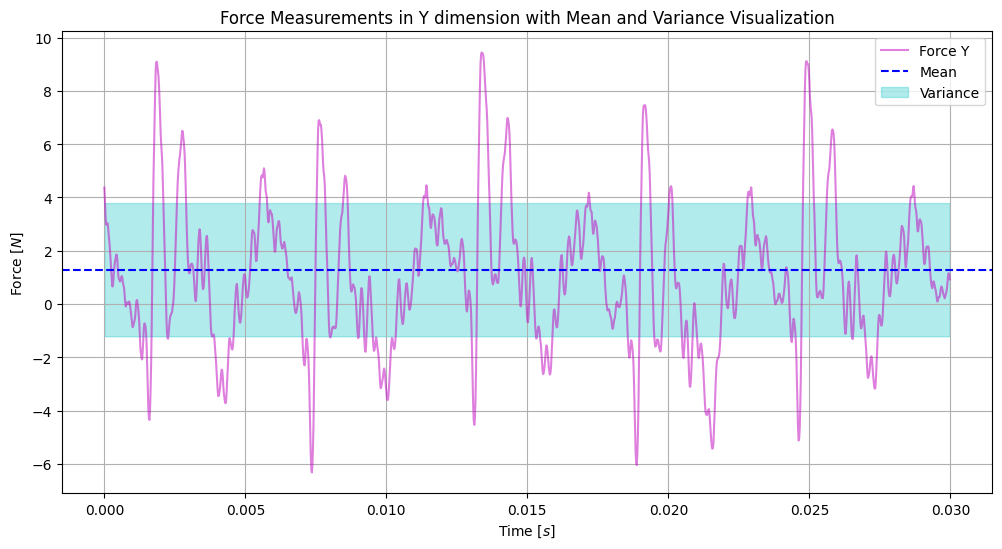

In [23]:
mean = data_cut['Force Y'].mean()
variance = data_cut['Force Y'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Y'][:1500], label='Force Y', color='m', alpha=0.5)
plt.axhline(mean, color='b', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:1500], mean - std_dev, mean + std_dev, color='c', alpha=0.3, label='Variance')
plt.title('Force Measurements in Y dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

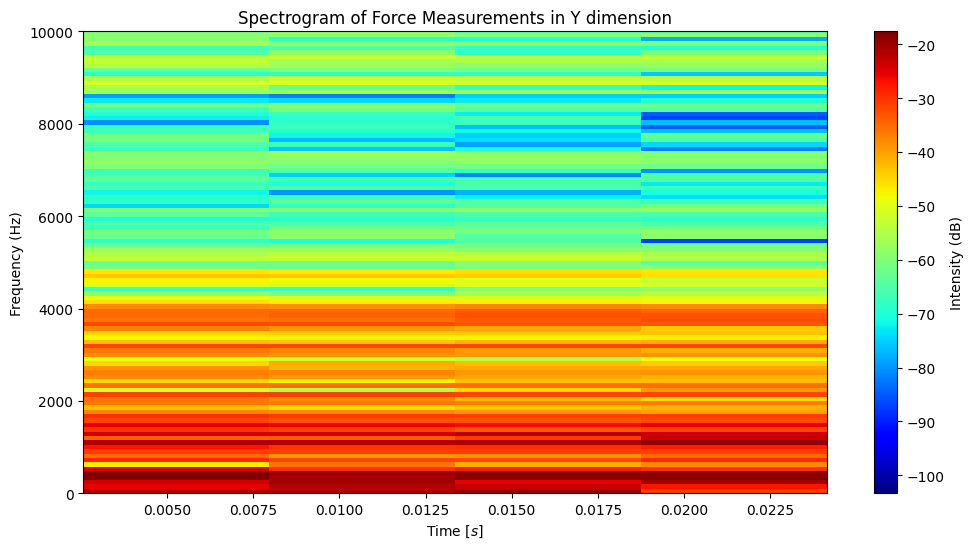

In [24]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Force Y'][:1500], Fs=1/sampling_interval, NFFT=526, noverlap=256, cmap='jet')
plt.title('Spectrogram of Force Measurements in Y dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 10000) 
plt.show()

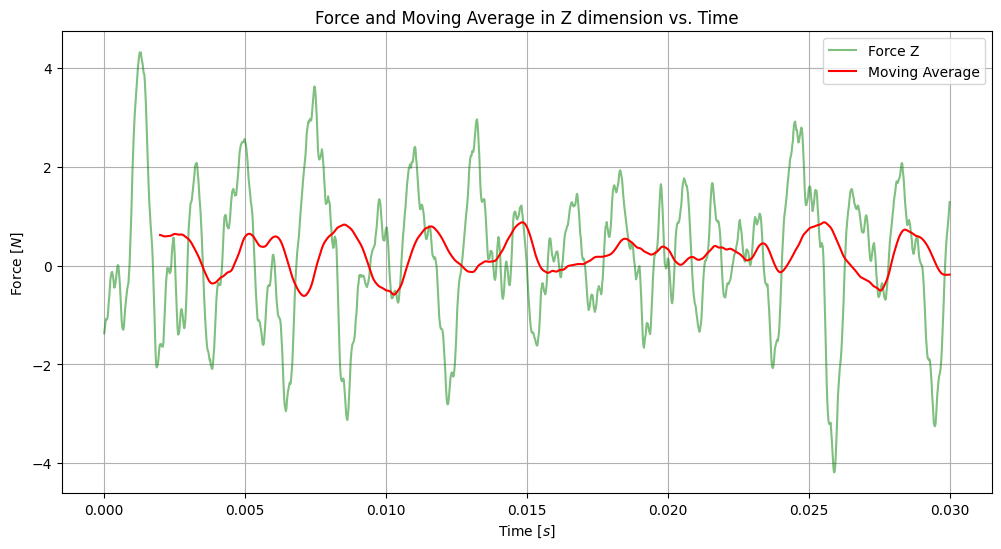

In [25]:
window_size = 100
data_cut['moving_average'] = data_cut['Force Z'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Z'][:1500], label='Force Z', color='g', alpha=0.5)
plt.plot(data_cut['time'][:1500], data_cut['moving_average'][:1500], label='Moving Average', color='r')
plt.title('Force and Moving Average in Z dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

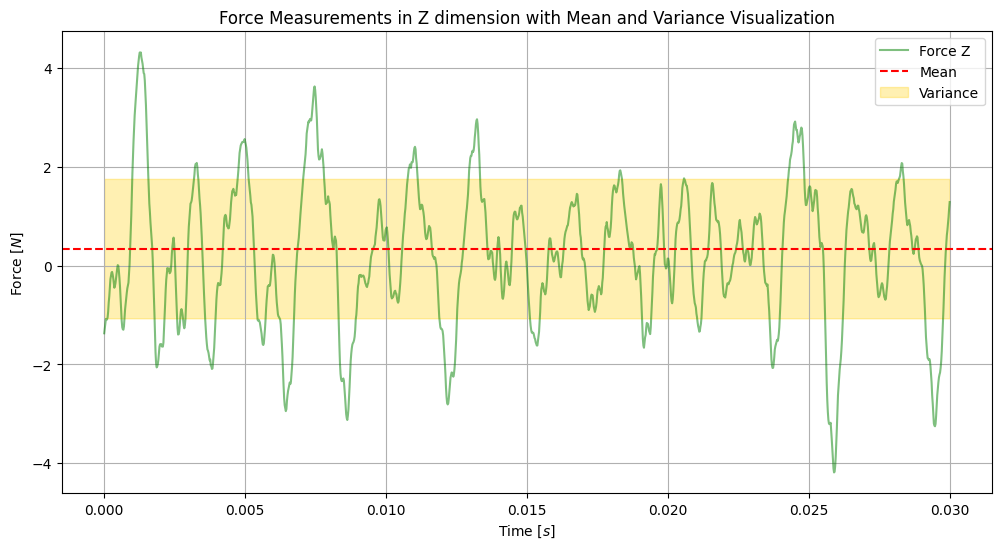

In [26]:
mean = data_cut['Force Z'].mean()
variance = data_cut['Force Z'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['Force Z'][:1500], label='Force Z', color='g', alpha=0.5)
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:1500], mean - std_dev, mean + std_dev, color='#FFCE00', alpha=0.3, label='Variance')
plt.title('Force Measurements in Z dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Force [$N$]')
plt.grid()
plt.legend()
plt.show()

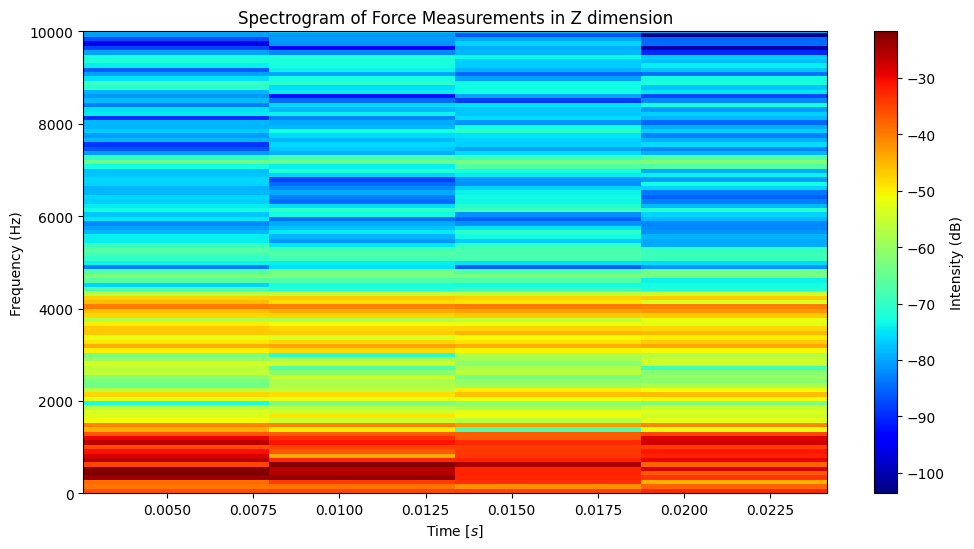

In [27]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Force Z'][:1500], Fs=1/sampling_interval, NFFT=526, noverlap=256, cmap='jet')
plt.title('Spectrogram of Force Measurements in Z dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 10000) 
plt.show()

### Vibration

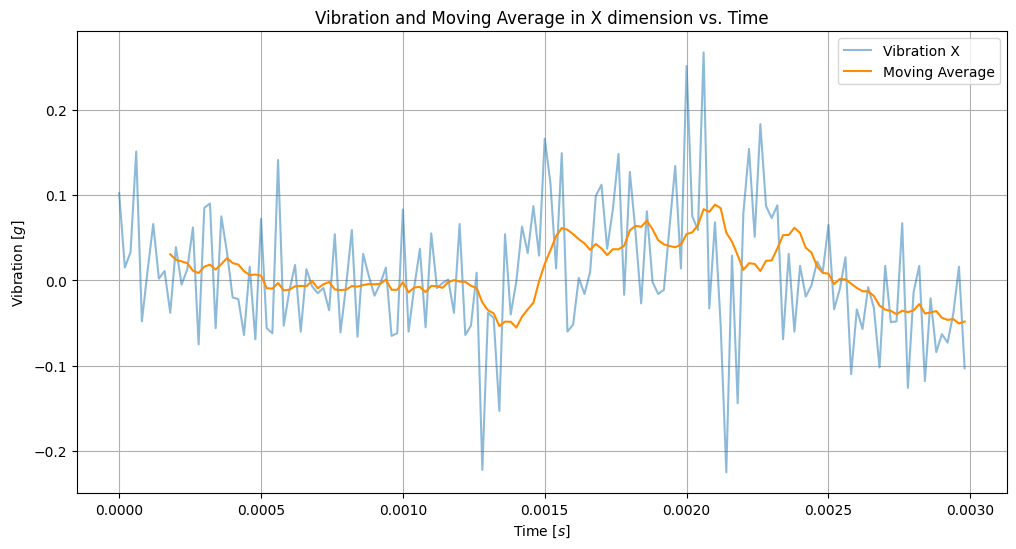

In [28]:
window_size = 10
data_cut['moving_average'] = data_cut['Vibration X'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration X'][:150], label='Vibration X', alpha=0.5)
plt.plot(data_cut['time'][:150], data_cut['moving_average'][:150], label='Moving Average', color='#FF8C00')
plt.title('Vibration and Moving Average in X dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

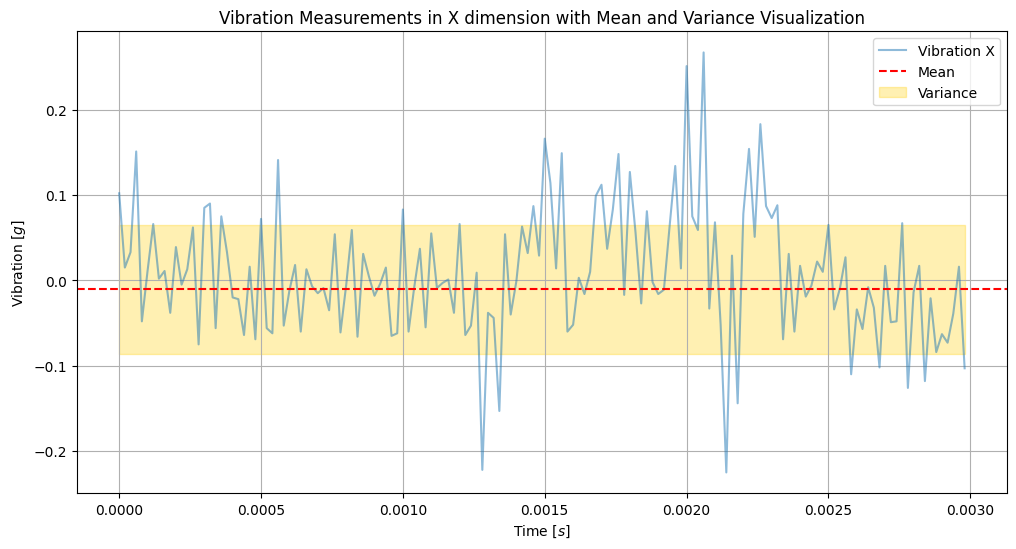

In [29]:
mean = data_cut['Vibration X'].mean()
variance = data_cut['Vibration X'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration X'][:150], label='Vibration X', alpha=0.5)
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:150], mean - std_dev, mean + std_dev, color='#FFCE00', alpha=0.3, label='Variance')
plt.title('Vibration Measurements in X dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

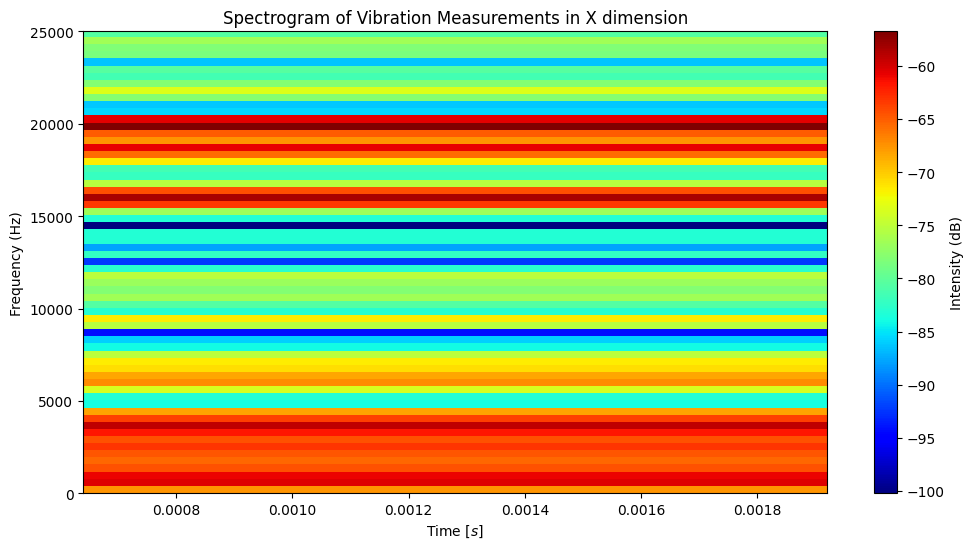

In [30]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Vibration X'][:150], Fs=1/sampling_interval, NFFT=128, noverlap=64, cmap='jet')
plt.title('Spectrogram of Vibration Measurements in X dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 25000) 
plt.show()

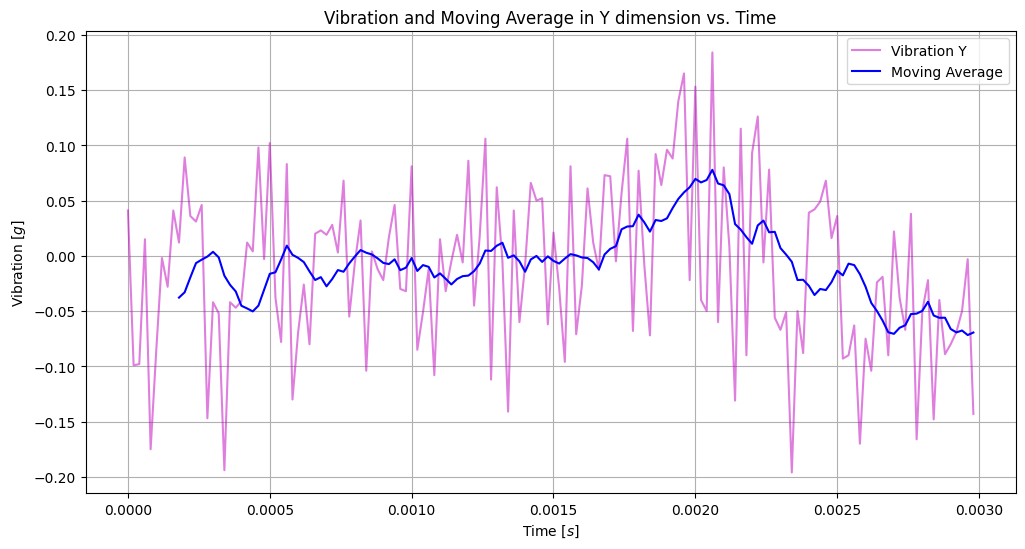

In [31]:
window_size = 10
data_cut['moving_average'] = data_cut['Vibration Y'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Y'][:150], label='Vibration Y', color='m', alpha=0.5)
plt.plot(data_cut['time'][:150], data_cut['moving_average'][:150], label='Moving Average', color='b')
plt.title('Vibration and Moving Average in Y dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

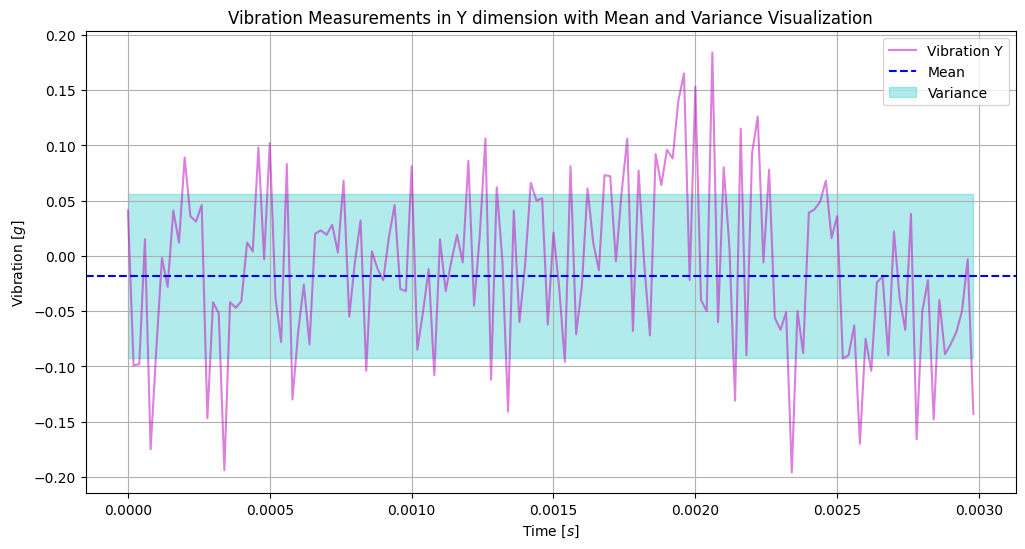

In [32]:
mean = data_cut['Vibration Y'].mean()
variance = data_cut['Vibration Y'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Y'][:150], label='Vibration Y', color='m', alpha=0.5)
plt.axhline(mean, color='b', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:150], mean - std_dev, mean + std_dev, color='c', alpha=0.3, label='Variance')
plt.title('Vibration Measurements in Y dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

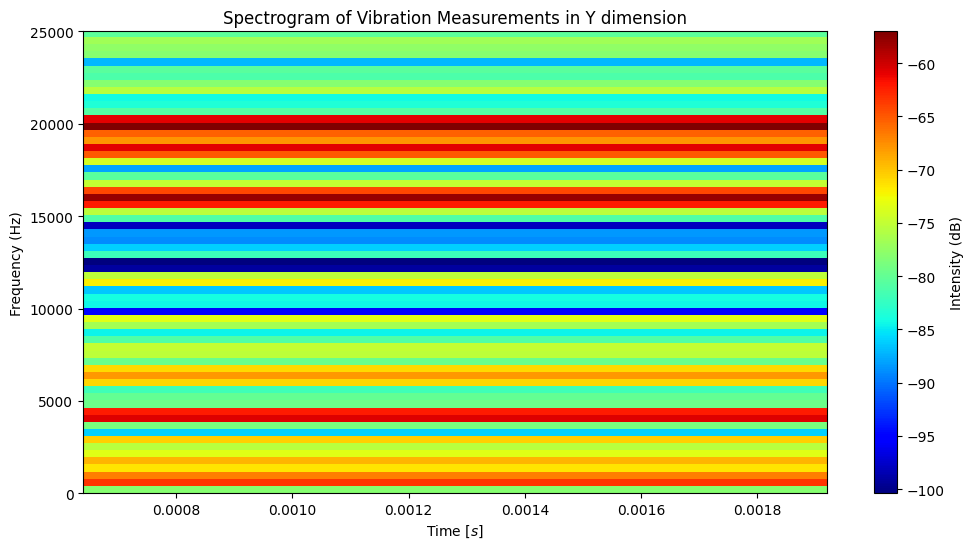

In [33]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Vibration Y'][:150], Fs=1/sampling_interval, NFFT=128, noverlap=64, cmap='jet')
plt.title('Spectrogram of Vibration Measurements in Y dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 25000) 
plt.show()

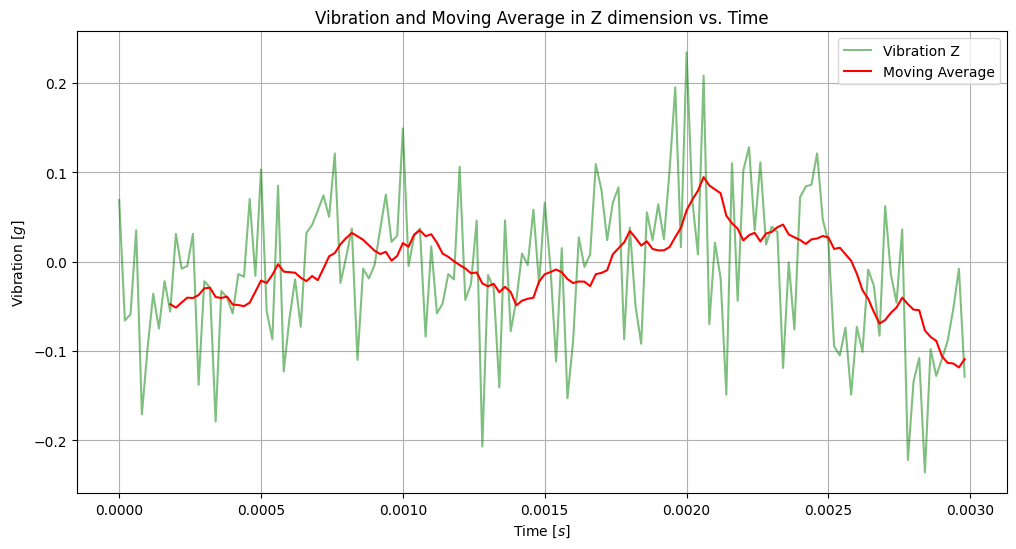

In [34]:
window_size = 10
data_cut['moving_average'] = data_cut['Vibration Z'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Z'][:150], label='Vibration Z', color='g', alpha=0.5)
plt.plot(data_cut['time'][:150], data_cut['moving_average'][:150], label='Moving Average', color='r')
plt.title('Vibration and Moving Average in Z dimension vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.legend()
plt.show()

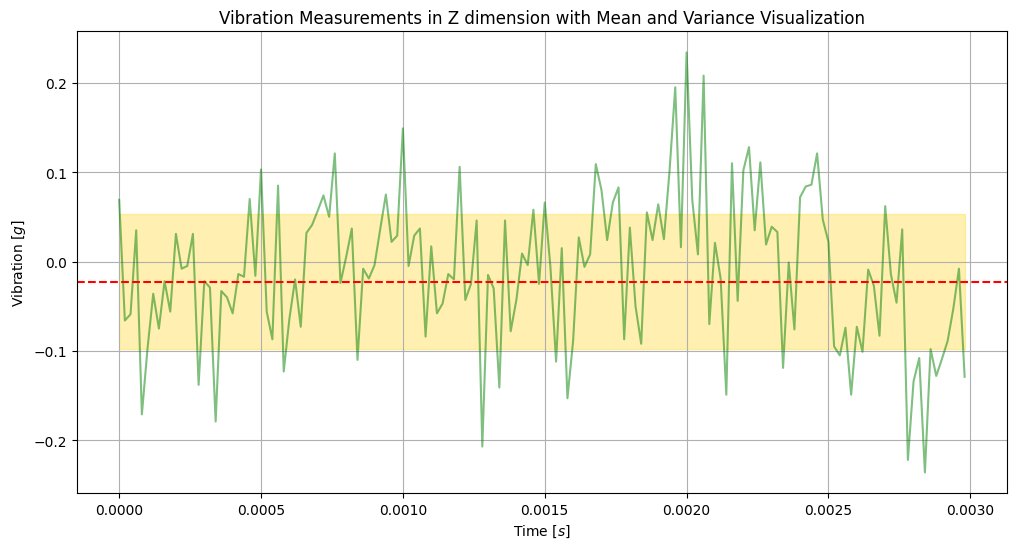

In [35]:
mean = data_cut['Vibration Z'].mean()
variance = data_cut['Vibration Z'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:150], data_cut['Vibration Z'][:150], label='Vibration Z', color='g', alpha=0.5)
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:150], mean - std_dev, mean + std_dev, color='#FFCE00', alpha=0.3, label='Variance')
plt.title('Vibration Measurements in Z dimension with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Vibration [$g$]')
plt.grid()
plt.show()

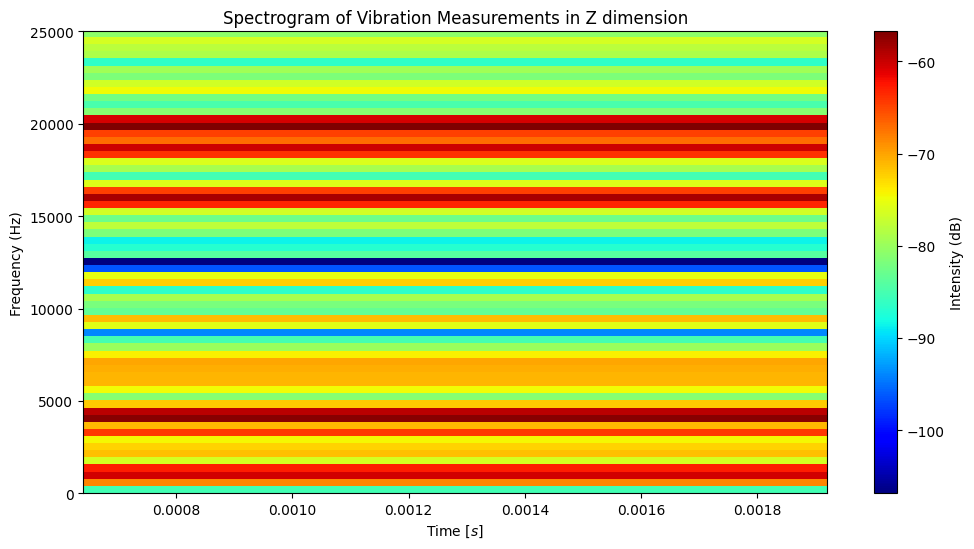

In [36]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['Vibration Z'][:150], Fs=1/sampling_interval, NFFT=128, noverlap=64, cmap='jet')
plt.title('Spectrogram of Vibration Measurements in Z dimension')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 25000) 
plt.show()

### Acoustic Emission

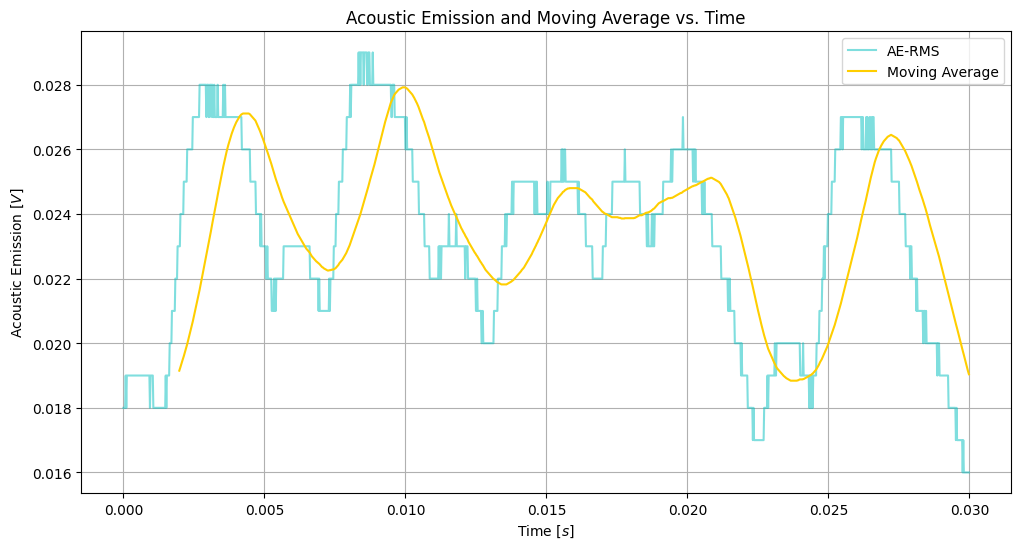

In [37]:
window_size = 100
data_cut['moving_average'] = data_cut['AE-RMS'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['AE-RMS'][:1500], label='AE-RMS', color='c', alpha=0.5)
plt.plot(data_cut['time'][:1500], data_cut['moving_average'][:1500], label='Moving Average', color='#FFCE00')
plt.title('Acoustic Emission and Moving Average vs. Time')
plt.xlabel('Time [$s$]')
plt.ylabel('Acoustic Emission [$V$]')
plt.grid()
plt.legend()
plt.show()

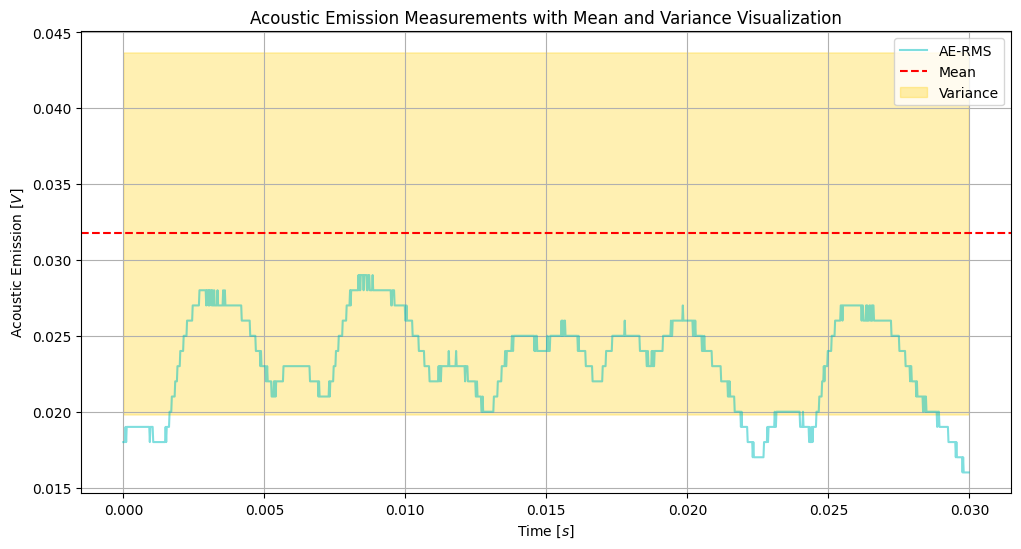

In [38]:
mean = data_cut['AE-RMS'].mean()
variance = data_cut['AE-RMS'].var()
std_dev = np.sqrt(variance)  # Standard deviation

plt.figure(figsize=(12, 6))
plt.plot(data_cut['time'][:1500], data_cut['AE-RMS'][:1500], label='AE-RMS', color='c', alpha=0.5)
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.fill_between(data_cut['time'][:1500], mean - std_dev, mean + std_dev, color='#FFCE00', alpha=0.3, label='Variance')
plt.title('Acoustic Emission Measurements with Mean and Variance Visualization')
plt.xlabel('Time [$s$]')
plt.ylabel('Acoustic Emission [$V$]')
plt.grid()
plt.legend(loc='upper right')
plt.show()

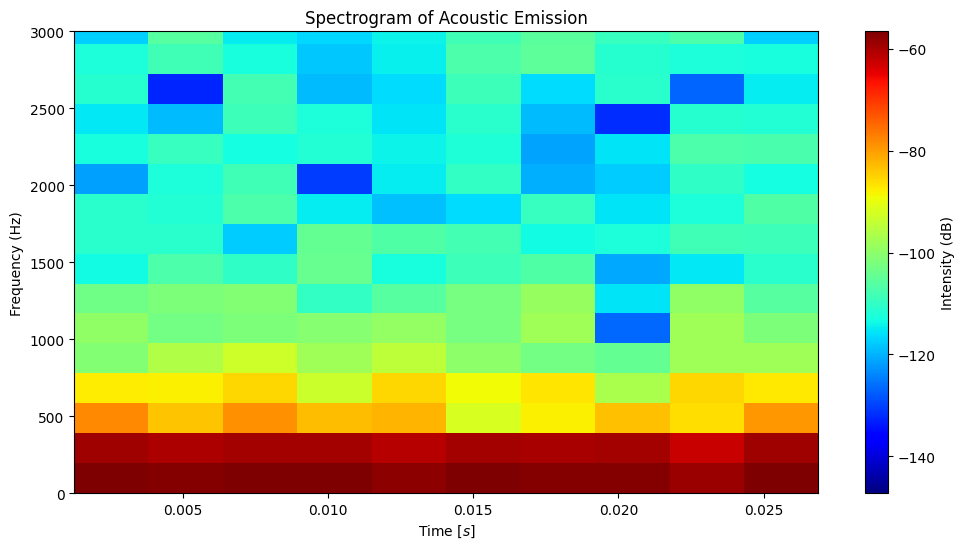

In [39]:
plt.figure(figsize=(12, 6))
plt.specgram(data_cut['AE-RMS'][:1500], Fs=1/sampling_interval, NFFT=256, noverlap=128, cmap='jet')
plt.title('Spectrogram of Acoustic Emission')
plt.xlabel('Time [$s$]')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)') 
plt.ylim(0, 3000) 
plt.show()